In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn

In [ ]:
!pip install evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f06f4a1d59c47123d38284fd7e6a600997bd1decd860b63de488b529f0b06eba
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


Loading and preparing train data...
Loading and preparing dev and test data...

Combined dev and test sets into a single final test set of 29517 sentences.

Processed 126169 training sentences for CRF.

Starting model training with CRF...


loading training data to CRFsuite: 100%|██████████| 126169/126169 [00:24<00:00, 5181.84it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 130347
Seconds required: 4.831

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=4.05  loss=2239978.05 active=128009 feature_norm=1.00
Iter 2   time=5.68  loss=1561631.22 active=126470 feature_norm=2.65
Iter 3   time=2.52  loss=1423259.56 active=123022 feature_norm=2.37
Iter 4   time=2.70  loss=1296796.01 active=123707 feature_norm=2.47
Iter 5   time=1.96  loss=1068664.98 active=126404 feature_norm=3.46
Iter 6   time=1.88  loss=589276.88 active=126468 feature_norm=8.04
Iter 7   time=1.97  loss=455769.64 active=124308 feature_norm=11.89
Iter 8   time=1.86  loss=355567.19 active=127935 feature_norm=13.41
Iter 9   time=2.32  loss=306245.25 active=128040 featur

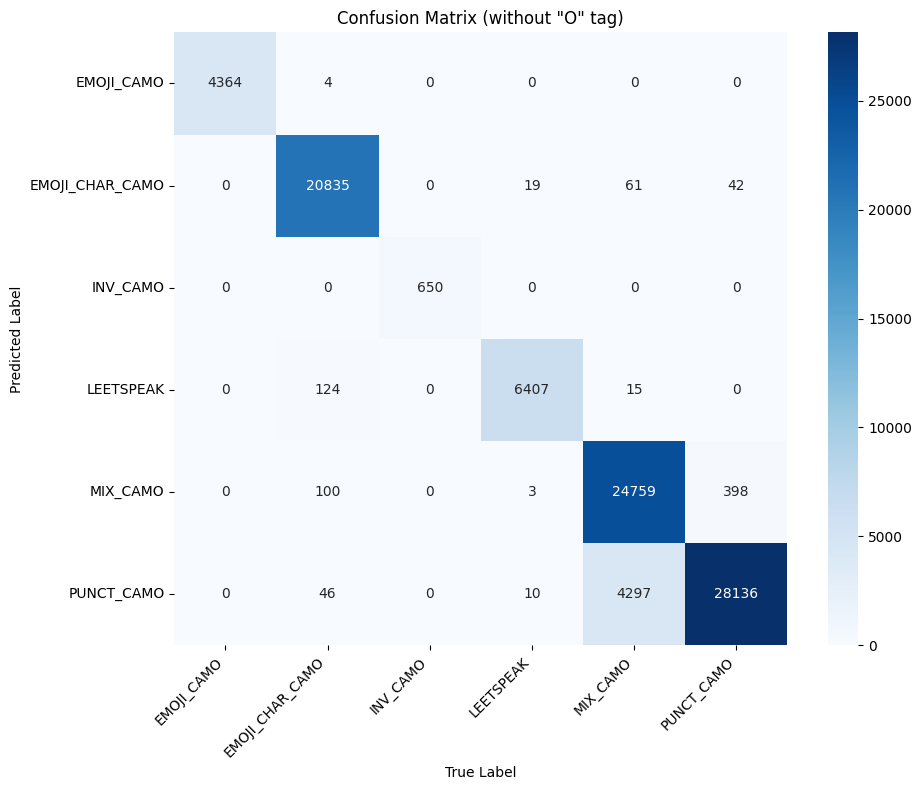

Metrics bar chart saved to: /content/drive/My Drive/Vidath/traditional_model/CRF/crf_final_metrics_barchart.png


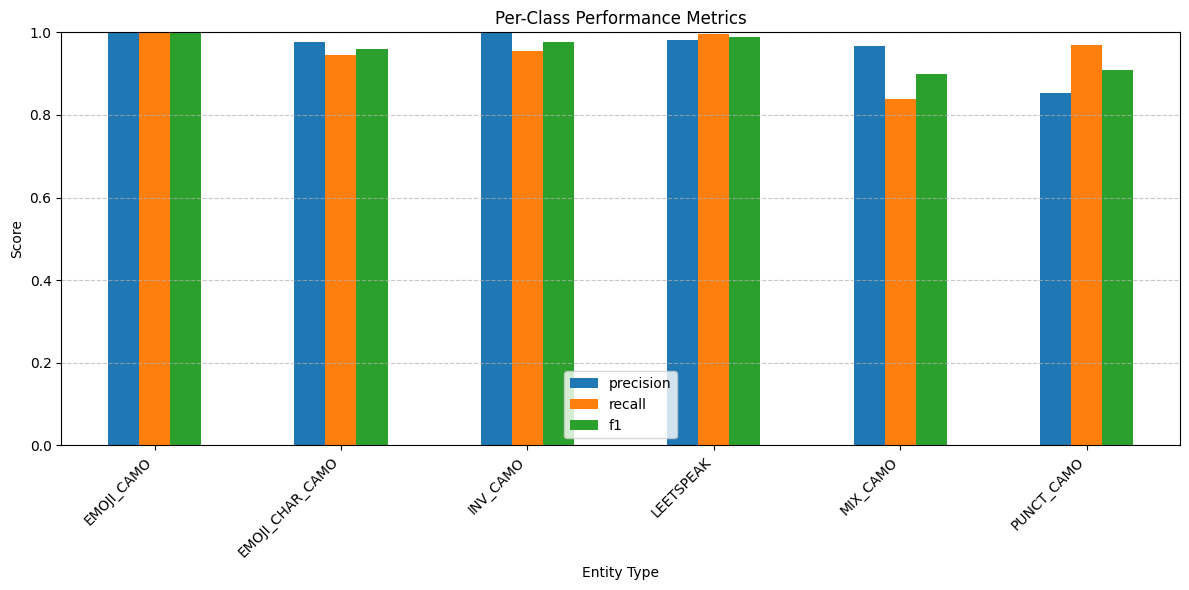


Model saved to /content/drive/My Drive/Vidath/traditional_model/CRF/crf-ner-model.joblib


In [ ]:
# 0. Install sklearn-crfsuite
try:
    import sklearn_crfsuite
except ImportError:
    print("Installing sklearn-crfsuite...")
    import subprocess
    subprocess.check_call(["pip", "install", "sklearn-crfsuite"])
    import sklearn_crfsuite

# 1. Imports and Setup
import pandas as pd
import numpy as np
import re
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics as crf_metrics
from sklearn.metrics import confusion_matrix
from evaluate import load
import joblib
import os

### --- Imports for visualization --- ###
import matplotlib.pyplot as plt
import seaborn as sns

# Need seqeval for metric computation (used for plotting)
try:
    from evaluate import load
    load("seqeval")
except ImportError:
    print("Installing seqeval and evaluate...")
    import subprocess
    subprocess.check_call(["pip", "install", "evaluate", "seqeval"])
    from evaluate import load

# 2. Labels and Feature Engineering (Identical to SVM version)
BASE_LABELS = ["LEETSPEAK", "PUNCT_CAMO", "INV_CAMO", "MIX_CAMO", "EMOJI_CAMO", "EMOJI_CHAR_CAMO"]
LABEL_LIST = ["O"] + [f"B-{label}" for label in BASE_LABELS] + [f"I-{label}" for label in BASE_LABELS]

def is_emoji(s):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F" "\U0001F300-\U0001F5FF" "\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F" "\U0001F780-\U0001F7FF" "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF" "\U0001FA00-\U0001FA6F" "\U0001FA70-\U0001FAFF"
        "\U00002702-\U000027B0" "\U000024C2-\U0001F251" "]+", flags=re.UNICODE,
    )
    return re.match(emoji_pattern, s) is not None

def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0, 'word.lower()': word.lower(), 'word[-3:]': word[-3:], 'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(), 'word.istitle()': word.istitle(), 'word.isdigit()': word.isdigit(),
        'word.has_digit': any(char.isdigit() for char in word), 'word.has_punct': any(not char.isalnum() for char in word),
        'word.is_emoji': is_emoji(word), 'word.has_emoji': any(is_emoji(char) for char in word),
    }
    if i > 0:
        prev_word = sent[i-1]
        features.update({'-1:word.lower()': prev_word.lower(), '-1:word.istitle()': prev_word.istitle(),
                         '-1:word.isupper()': prev_word.isupper(), '-1:word.is_emoji': is_emoji(prev_word)})
    else: features['BOS'] = True
    if i < len(sent)-1:
        next_word = sent[i+1]
        features.update({'+1:word.lower()': next_word.lower(), '+1:word.istitle()': next_word.istitle(),
                         '+1:word.isupper()': next_word.isupper(), '+1:word.is_emoji': is_emoji(next_word)})
    else: features['EOS'] = True
    return features

def sent2features(sent): return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(labels): return labels
def sent2tokens(sent): return sent

def load_and_prepare_data_crf(file_path):
    df = pd.read_csv(file_path, encoding='utf-8')
    grouped = df.groupby('Text').apply(lambda x: x.to_dict('records'), include_groups=False).reset_index(name='entities')
    sentences = []
    for _, row in grouped.iterrows():
        text = str(row['Text']) if pd.notna(row['Text']) else ""
        entities = row['entities']
        tokens_with_spans = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\w+|[^\s\w]', text)]
        tokens = [t[0] for t in tokens_with_spans]
        labels = ['O'] * len(tokens)
        for entity in entities:
            ent_start, ent_end, ent_label = entity['Start'], entity['End'], entity['Label']
            if f"B-{ent_label}" not in LABEL_LIST: continue
            in_entity = False
            for i, (token, tok_start, tok_end) in enumerate(tokens_with_spans):
                if max(tok_start, ent_start) < min(tok_end, ent_end):
                    labels[i] = f"B-{ent_label}" if not in_entity else f"I-{ent_label}"
                    in_entity = True
                else: in_entity = False
        sentences.append((tokens, labels))
    return sentences

# 3. Data Loading and Preparation
print("Loading and preparing train data...")
train_sents = load_and_prepare_data_crf("/content/drive/My Drive/Vidath/Dataset/augmented_train_all_combo_emoji.csv")
print("Loading and preparing dev and test data...")
dev_sents = load_and_prepare_data_crf("/content/drive/My Drive/Vidath/Dataset/augmented_dev_all_combo_emoji.csv")
test_sents = load_and_prepare_data_crf("/content/drive/My Drive/Vidath/Dataset/augmented_test_all_combo_emoji.csv")
combined_test_sents = dev_sents + test_sents
print(f"\nCombined dev and test sets into a single final test set of {len(combined_test_sents)} sentences.")

# Prepare data for sklearn-crfsuite format
X_train = [sent2features(s[0]) for s in train_sents]
y_train = [sent2labels(s[1]) for s in train_sents]
X_test = [sent2features(s[0]) for s in combined_test_sents]
y_test = [sent2labels(s[1]) for s in combined_test_sents]

print(f"\nProcessed {len(X_train)} training sentences for CRF.")

# 4. Model Training
print("\nStarting model training with CRF...")
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)
crf.fit(X_train, y_train)

# 5. Evaluation and Reporting
labels = list(crf.classes_)
labels.remove('O') # Remove 'O' for a cleaner report

print("\n--- Detailed Evaluation on Combined Test Set (CRF) ---")
y_pred = crf.predict(X_test)

# sklearn-crfsuite has its own metrics module, which is excellent.
# We'll use it for the text report.
report = crf_metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=4)
print("\nFinal Test Set Classification Report:")
print(report)

# For plotting, we can reuse the functions with the seqeval-style dictionary
metric_loader = load("seqeval")
results_dict = metric_loader.compute(predictions=y_pred, references=y_test)
test_report_clean = {k: v if not (isinstance(v, dict) and 'f1-score' in v) else (lambda d: {**d, 'f1': d.pop('f1-score')})(v.copy()) for k, v in results_dict.items()}

# --- Reusable Plotting Functions ---
def aggregate_bio_tags(labels): return [label[2:] if label not in ['O'] else 'O' for label in labels]
def plot_confusion_matrix(y_true, y_pred, labels, save_path):
    labels_without_o = sorted([l for l in labels if l != 'O'])
    y_true_flat, y_pred_flat = [item for sublist in y_true for item in sublist], [item for sublist in y_pred for item in sublist]
    y_true_agg, y_pred_agg = aggregate_bio_tags(y_true_flat), aggregate_bio_tags(y_pred_flat)
    mat = confusion_matrix(y_true_agg, y_pred_agg, labels=labels_without_o)
    plt.figure(figsize=(10, 8)); sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, xticklabels=labels_without_o, yticklabels=labels_without_o, cmap="Blues")
    plt.title('Confusion Matrix (without "O" tag)'); plt.xlabel('True Label'); plt.ylabel('Predicted Label')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight'); print(f"Confusion matrix saved to: {save_path}"); plt.show()

def plot_metrics_barchart(report_dict, save_path):
    class_data = {label: metrics for label, metrics in report_dict.items() if isinstance(metrics, dict)}
    df = pd.DataFrame(class_data).T.reset_index().rename(columns={'index': 'Entity'})
    df.plot(x='Entity', y=['precision', 'recall', 'f1'], kind='bar', figsize=(12, 6))
    plt.title('Per-Class Performance Metrics'); plt.ylabel('Score'); plt.xlabel('Entity Type')
    plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.ylim(0, 1)
    plt.tight_layout(); plt.savefig(save_path, bbox_inches='tight'); print(f"Metrics bar chart saved to: {save_path}"); plt.show()

plots_dir = "/content/drive/My Drive/Vidath/traditional_model/CRF"
os.makedirs(plots_dir, exist_ok=True)
cm_save_path = os.path.join(plots_dir, "crf_final_confusion_matrix.png")
plot_confusion_matrix(y_test, y_pred, labels=BASE_LABELS, save_path=cm_save_path)
metrics_save_path = os.path.join(plots_dir, "crf_final_metrics_barchart.png")
plot_metrics_barchart(test_report_clean, save_path=metrics_save_path)

# 6. Save Model and Predict
model_path = "/content/drive/My Drive/Vidath/traditional_model/CRF/crf-ner-model.joblib"
joblib.dump(crf, model_path)
print(f"\nModel saved to {model_path}")

def predict_ner_crf(text, model):
    tokens_with_spans = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\w+|[^\s\w]', text)]
    if not tokens_with_spans: return []
    tokens = [t[0] for t in tokens_with_spans]
    features = sent2features(tokens)
    predicted_labels = model.predict([features])[0] # predict expects a list of sentences
    entities, current_entity = [], None
    for i, label in enumerate(predicted_labels):
        token, start, end = tokens_with_spans[i]
        if label.startswith("B-"):
            if current_entity: entities.append(current_entity)
            current_entity = {"label": label[2:], "start": start, "end": end}
        elif label.startswith("I-") and current_entity and label[2:] == current_entity["label"]:
            current_entity["end"] = end
        else:
            if current_entity: entities.append(current_entity)
            current_entity = None
    if current_entity: entities.append(current_entity)
    for entity in entities: entity["entity"] = text[entity["start"]:entity["end"]]
    return entities